The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/tvm-0.7.dev1-cp37-cp37m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/topi-0.7.dev1-py3-none-any.whl
!pip install git+https://github.com/d2l-ai/d2l-tvm


# Broadcast Add

:label:`ch_bcast_add_cpu`


This section talks about scheduling the broadcast add computation defined in :numref:`ch_bcast_add` on CPU. The optimization of it is similar to what we have done for vector add in :numref:`ch_vector_add_cpu`, as they are both essentially memory-bound element-wise calculation. Hence, instead of "what works", we will talk about "what doesn't work" in this section.

## Setup

In [1]:
%matplotlib inline
import d2ltvm
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm
from tvm import te

Here we choose the broadcast add depicted in :numref:`fig_bcast_add`. The other broadcast patterns do not make essential difference.

First, we define the baseline in `numpy`. We use the real used data sizes in the x axis.

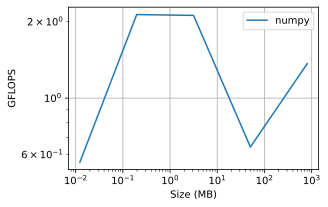

In [2]:
sizes = 2**np.arange(5, 15, 2)
np_bcast_add = lambda s1, s2: timeit.Timer(setup='import numpy as np\n'
                                'import d2ltvm\n'
                                'a, b, c = d2ltvm.get_bcast_data(%s, %s)' % (s1, s2),
                                stmt='np.add(a, b, out=c)')
exe_times = [d2ltvm.bench_workload(np_bcast_add((n, 1), (n, n)).timeit) for n in sizes]
np_gflops = sizes * sizes / 1e9 / np.array(exe_times)
# data size in MB
x_axis_sizes = (sizes * sizes * 2 + sizes * sizes) * 4 / 1e6
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops], ['numpy'], xlabel='Size (MB)')

Note that the x axis is denoted as the total data size consumed. The performance drops when the data size is larger than the L2 cache of a single core (1024 KB or 1 MB), which indirectly suggests that `numpy` may use single-thread to perform this operator.

## Good Schedule

The following code block defines a benchmarking method for broadcast add of a specific pattern in TVM. It follows the same format we discussed in :numref:`ch_vector_add_cpu`.

In [3]:
# Save to the d2ltvm package.
def bench_bcast_add_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, ctx=ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        n = int(n)
        s, (A, B, C) = func(n)
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.context(target, 0)
        a, b, c = d2ltvm.get_bcast_data((n, 1), (n, n), lambda x: tvm.nd.array(x, ctx=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return sizes * sizes / 1e9 / np.array(times)

The good schedule (i.e. what works) follows the similar scheme defined in :numref:`ch_vector_add_cpu`.

In [4]:
target = 'llvm -mcpu=skylake-avx512'
def default(n):
    A, B, C = d2ltvm.broadcast_add((n, 1), (n, n))
    s = te.create_schedule(C.op)
    return s, (A, B, C)

def good_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].parallel(x)
    s[C].vectorize(y)
    return s, (A, B, C)

s, args = good_schedule(64)
print(tvm.lower(s, args, simple_mode=True))

produce C {
  parallel (x, 0, 64) {
    C[ramp((x*64), 1, 64)] = (x64(A[x]) + B[ramp((x*64), 1, 64)])
  }
}



Now the C-like pseudo code should be familiar to you. One notable difference from :numref:ch_vector_add_cpu is that we broadcast `A[x]` to a vectorized register (i.e. `x64(A[x]`) for vectorized add.

Let's benchmark the good schedule.

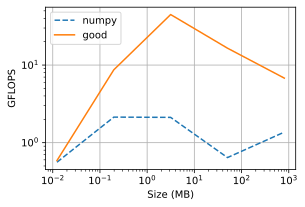

In [5]:
good_gflops = bench_bcast_add_tvm(good_schedule, sizes, target)
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops, good_gflops], ['numpy', 'good'], xlabel='Size (MB)')

Like the case in :numref:`ch_vector_add_cpu`, the performance is better and drops at a larger data size as multi-core comes into play, leading to a larger amount L2 cache in total.

## Bad Schedule

Now let's see how a bad schedule (i.e. what doesn't work) looks like. Note that our data are all stored in row-major and our schedules always make sure that the innermost loop manipulates the data in consecutive space.

However, if we think from the perspective vectorization, we may find that broadcasting `A[x]` to a vectorized register brings overhead. A better way is to have multiple values of `A` to add with multiple values of `B` in a vectorized instruction, which is illustrated in :numref:`fig_bcast_add_vectorize`.

![Different vectorization strategies of broadcast add.](http://tvm.d2l.ai/_images/bcast_add_vectorize.svg)

:label:`fig_bcast_add_vectorize`


In order to make vectorization along the column, we need to reorder to data access pattern as follows.

In [6]:
def bad_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].reorder(y, x)
    s[C].parallel(y)
    s[C].vectorize(x)
    return s, (A, B, C)

s, args = bad_schedule(64)
print(tvm.lower(s, args, simple_mode=True))

produce C {
  parallel (y, 0, 64) {
    C[ramp(y, 64, 64)] = (A[ramp(0, 1, 64)] + B[ramp(y, 64, 64)])
  }
}



Now we eliminate the broadcast of `A[x]` in vectorization. Let's run the benchmark and plot the chart for this schedule.

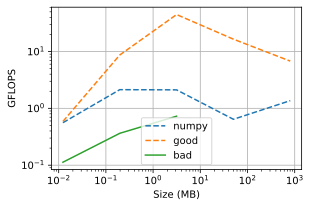

In [7]:
sizes = 2**np.arange(5, 11, 2)
bad_gflops = bench_bcast_add_tvm(bad_schedule, sizes, target)
diff = len(good_gflops)-len(bad_gflops)
bad_gflops = np.append(bad_gflops, [np.nan] * diff)
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops, good_gflops, bad_gflops],
     ['numpy', 'good', 'bad'],  xlabel='Size (MB)')

Note that in order to make it finish in a short period of time, we reduce the number of tested sizes for this schedule.

We can see that the performance of the vectorization-favorable schedule is pretty bad. The reason is that we access `B` in a stride to get the data in the same column, which is much slower than accessing data in a consecutive space. And the thread-level parallelism would make it even worse as different threads compete in getting the data in the same cache line.

The result shows that a good schedule needs to consider multiple performance-related factors together. A scheduling scheme that favors one aspect may lead to bad overall performance as it harms other aspects.

## Summary

- Like vector add, broadcast add is a memory-bound operator.
- A good schedule needs to consider multiple performance-related factors together.

## Exercise

- Try to schedule other broadcast add patterns and observe the difference.